In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.font_manager as fm
from datetime import datetime, timedelta

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
file_path = 'data_input_auto/山东柴油裂解差Trend-F=0.2.xlsx'
target_column = '山东柴油裂解差Trend/F=0.2'

sheet = pd.read_excel(file_path, sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet[target_column].last_valid_index()

In [4]:
future_days = pd.date_range(start=last_day + pd.Timedelta(days=1), periods=45, freq='B')[:30]
sheet = sheet.reindex(sheet.index.union(future_days)).sort_index()


# 填充缺失的因子数据
fill_methods = {
    '中国中央政府杠杆率同差': 'interpolate', 
    '申万行业指数：钢结构': 'interpolate',
    '固定资产投资本年施工项目计划总投资额:累计同比': 'interpolate', 
    'M1同比': 'interpolate', 
    '工业企业营业收入利润率Trend（0.2）': 'interpolate',
    '南华工业品指数/250DMA同比': 'interpolate', 
    '居民用电12月移动均值同比': 'interpolate', 
    '地方政府专项债新增当月值(wind)/12MMATrend ': 'interpolate',
}
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, '山东柴油裂解差Trend/F=0.2'] = sheet.loc[:last_day, '山东柴油裂解差Trend/F=0.2'].interpolate(method='linear')
sheet.loc[:last_day, '山东柴油裂解差'] = sheet.loc[:last_day, '山东柴油裂解差'].interpolate(method='linear')

# 因子平滑处理
smooth_window = 180  # 5天移动平均，轻度平滑
for col in fill_methods.keys():
    sheet[f'{col}_平滑'] = sheet[col].rolling(window=smooth_window, min_periods=1).mean()


# 创建提前期因子
sheet['中国中央政府杠杆率同差_平滑_提前100天'] = sheet['中国中央政府杠杆率同差_平滑'].shift(60)
sheet['申万行业指数：钢结构_平滑_提前320天'] = sheet['申万行业指数：钢结构_平滑'].shift(30)
sheet['固定资产投资本年施工项目计划总投资额:累计同比_平滑_提前260天'] = sheet['固定资产投资本年施工项目计划总投资额:累计同比_平滑'].shift(100)
sheet['M1同比_平滑_提前440天'] = sheet['M1同比_平滑'].shift(440)
sheet['工业企业营业收入利润率Trend（0.2）_平滑_提前200天'] = sheet['工业企业营业收入利润率Trend（0.2）_平滑'].shift(120)
sheet['南华工业品指数/250DMA同比_平滑_提前210天'] = sheet['南华工业品指数/250DMA同比_平滑'].shift(210)
sheet['居民用电12月移动均值同比_平滑_提前140天'] = sheet['居民用电12月移动均值同比_平滑'].shift(80)
sheet['地方政府专项债新增当月值(wind)/12MMATrend _平滑_提前120天'] = sheet['地方政府专项债新增当月值(wind)/12MMATrend _平滑'].shift(120)


# 创建逆序列
sheet['中国中央政府杠杆率同差_平滑_提前100天_逆序'] = -sheet['中国中央政府杠杆率同差_平滑_提前100天']


# 重置索引并筛选最近几年的数据
daily_data = sheet.reset_index().rename(columns={'index': 'Date'})
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
daily_data = daily_data[daily_data['Date'] >= pd.Timestamp('2020-01-01')]

# 只保留工作日
daily_data = daily_data[daily_data['Date'].dt.dayofweek < 5]
daily_data = daily_data.reset_index(drop=True)


# 删除 在 last_day 之前 预测标的 为 空值的 行
daily_data = daily_data[
    (daily_data['Date'] > last_day) | 
    (daily_data[target_column].notna())
]

In [5]:
# 将数据转换为周度数据,每周五为统计日期
weekly_data = daily_data.set_index('Date').resample('W-FRI').mean()
weekly_data = weekly_data.reset_index()
# 删除 last_day 之前空缺的行
# 在 last_day 之前的空缺值进行线性填充
weekly_data.loc[weekly_data['Date'] <= last_day] = weekly_data.loc[weekly_data['Date'] <= last_day].interpolate(method='linear')
weekly_data.tail()

,Date,山东柴油裂解差Trend/F=0.2,山东柴油裂解差,中国中央政府杠杆率同差,申万行业指数：钢结构,固定资产投资本年施工项目计划总投资额:累计同比,M1同比,工业企业营业收入利润率Trend（0.2）,南华工业品指数/250DMA同比,居民用电12月移动均值同比,...,地方政府专项债新增当月值(wind)/12MMATrend _平滑,中国中央政府杠杆率同差_平滑_提前100天,申万行业指数：钢结构_平滑_提前320天,固定资产投资本年施工项目计划总投资额:累计同比_平滑_提前260天,M1同比_平滑_提前440天,工业企业营业收入利润率Trend（0.2）_平滑_提前200天,南华工业品指数/250DMA同比_平滑_提前210天,居民用电12月移动均值同比_平滑_提前140天,地方政府专项债新增当月值(wind)/12MMATrend _平滑_提前120天,中国中央政府杠杆率同差_平滑_提前100天_逆序
273,2025-03-28,NaN,NaN,2.4,2293.91,4.0,0.1,5.346815,0.0117,0.0647,...,3261.048692,2.842319,1935.423244,4.537269,5.078728,5.402645,0.037293,0.026224,2919.187881,-2.842319
274,2025-04-04,NaN,NaN,2.4,2293.91,4.0,0.1,5.346815,0.0117,0.0647,...,3276.400297,2.836887,1938.542633,4.449922,4.993188,5.398788,0.037482,0.027413,2924.273040,-2.836887
275,2025-04-11,NaN,NaN,2.4,2293.91,4.0,0.1,5.346815,0.0117,0.0647,...,3291.183493,2.830141,1946.250767,4.354211,4.906968,5.394984,0.037850,0.028835,2930.438552,-2.830141
276,2025-04-18,NaN,NaN,2.4,2293.91,4.0,0.1,5.346815,0.0117,0.0647,...,3305.398467,2.822293,1955.685833,4.262840,4.821336,5.391232,0.038423,0.030533,2937.774139,-2.822293
277,2025-04-25,NaN,NaN,2.4,2293.91,4.0,0.1,5.346815,0.0117,0.0647,...,3319.055016,2.813342,1967.536111,4.177465,4.737932,5.387533,0.039171,0.032532,2946.342437,-2.813342


In [6]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
weekly_data = weekly_data.set_index('Date')
weekly_data.index = pd.date_range(start=weekly_data.index.min(), periods=len(weekly_data), freq='W-FRI')

train_data = weekly_data[weekly_data.index <= last_day].copy()
test_period = 10
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = weekly_data[weekly_data.index  > last_day].copy()

feature_columns = [
       '申万行业指数：钢结构_平滑_提前320天',
       '固定资产投资本年施工项目计划总投资额:累计同比_平滑_提前260天', 
       'M1同比_平滑_提前440天',
       '工业企业营业收入利润率Trend（0.2）_平滑_提前200天', 
       '南华工业品指数/250DMA同比_平滑_提前210天',
       '居民用电12月移动均值同比_平滑_提前140天', 
       '地方政府专项债新增当月值(wind)/12MMATrend _平滑_提前120天',
       '中国中央政府杠杆率同差_平滑_提前100天_逆序'
]

predict_column = '山东柴油裂解差Trend/F=0.2'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

In [7]:
# 初始化 StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)


# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 降低学习率以避免过拟合
    'max_depth': 3,  # 减小树的深度以减少过拟合
    'min_child_weight': 3,  # 增加以防止过拟合
    'subsample': 0.8,  # 减小以增加模型稳定性
    'colsample_bytree': 0.8,  # 特征采样比例
    'gamma': 0.1,  # 增加以控制过拟合
    'reg_alpha': 0.1,  # L1正则化
    'reg_lambda': 1.0,  # L2正则化
    'eval_metric': 'rmse',  # 评估指标
    'seed': 42,  # 随机种子
    'booster': 'gblinear',  # 使用树模型而不是线性模型
    'n_estimators': 1000,  # 增加树的数量
    'tree_method': 'auto'
}


num_boost_round = 2000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=500,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix =  model.predict(test_dmatrix)


train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")


##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:151.03593	train-rmse:127.07260
[500]	eval-rmse:3.41434	train-rmse:38.81955


c:\Users\hzins\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:43:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "n_estimators", "subsample", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	eval-rmse:3.22512	train-rmse:38.66246
[1500]	eval-rmse:3.21990	train-rmse:38.65831
[1999]	eval-rmse:3.21978	train-rmse:38.65824
训练集 MSE (DMatrix): 1494.7926, 训练集 R² (DMatrix): 0.9108
测试集 MSE (DMatrix): 10.3669, 测试集 R² (DMatrix): 0.4279


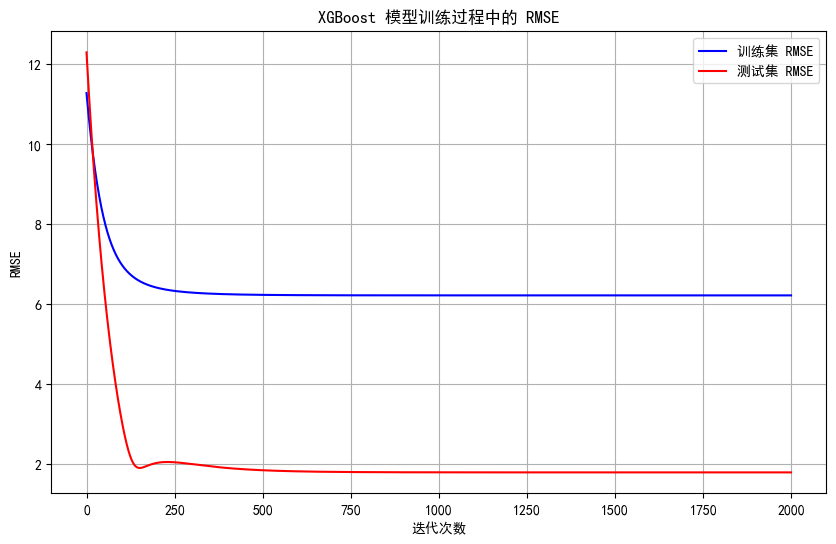

In [8]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################

# 确保数据拼接后索引是连续的，防止数据对不齐
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

# 对所有数据进行标准化（使用之前拟合的 scaler）
X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=100
)

# 对全部数据进行预测（X_train + X_test）
y_all_pred = model_all.predict(all_data_dmatrix)

# 对未来数据进行预测
y_future_pred_all = model_all.predict(future_dmatrix_all)

# 计算全部数据的 MSE 和 R² 分数
all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

# 打印结果
print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred

# 存储未来预测结果
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:127.57364
[100]	train-rmse:48.60556
[200]	train-rmse:41.22992
[300]	train-rmse:39.65350
[400]	train-rmse:39.11973
[500]	train-rmse:38.90168
[600]	train-rmse:38.80590
[700]	train-rmse:38.76233
[800]	train-rmse:38.74202
[900]	train-rmse:38.73241
[1000]	train-rmse:38.72780


c:\Users\hzins\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:43:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "n_estimators", "subsample", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


[1100]	train-rmse:38.72556
[1200]	train-rmse:38.72446
[1300]	train-rmse:38.72392
[1400]	train-rmse:38.72361
[1500]	train-rmse:38.72354
[1600]	train-rmse:38.72351
[1700]	train-rmse:38.72347
[1800]	train-rmse:38.72347
[1808]	train-rmse:38.72348
全部数据 MSE: 1501.2586, 全部数据 R²: 0.9117


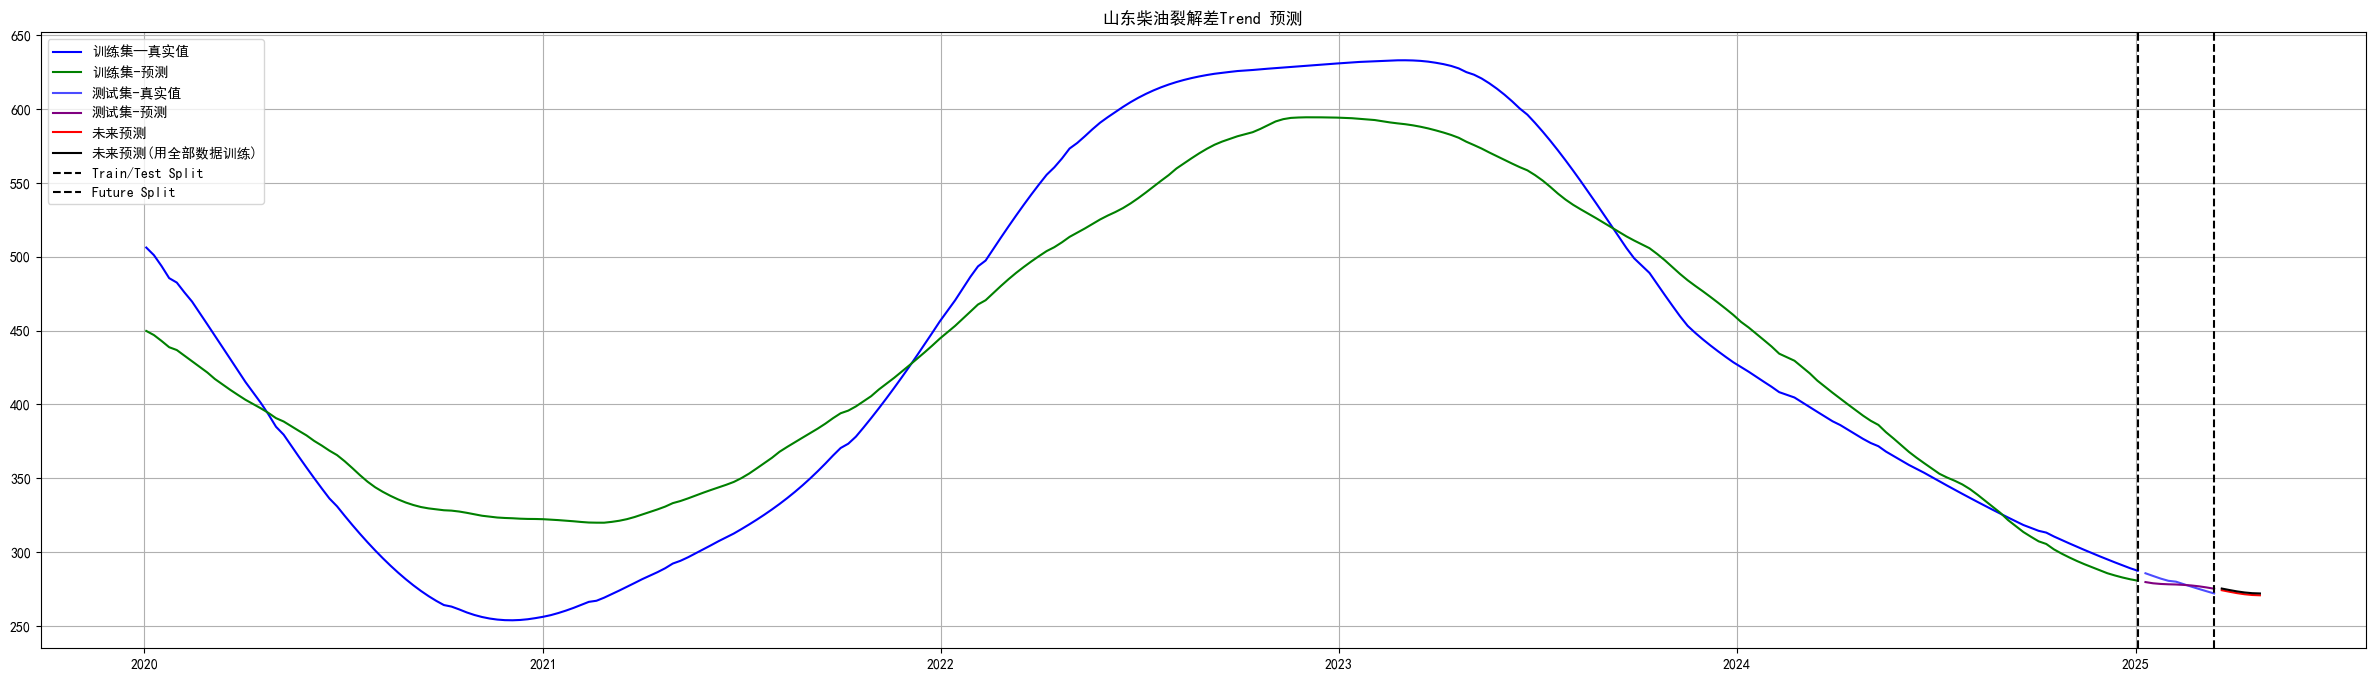

In [10]:
# 可视化
plt.figure(figsize=(30, 8))
plt.plot(train_data.index, y_train, label='训练集—真实值', color='blue')
plt.plot(train_data.index, y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data.index, y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data.index, y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data.index, future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data.index, future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')


plt.axvline(x=train_data.index[-1], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('山东柴油裂解差Trend 预测')
plt.legend()
plt.grid(True)
plt.show()
